In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

### Data Cleaning

In [21]:
def melt_to_long(
    df: pd.DataFrame,
    condition_col: str = "Condition",
    primer_col: str = "Primer",
    value_col: str = "Value",
    dropna: bool = True,
    preserve_order: bool = True,
) -> pd.DataFrame:
    if condition_col not in df.columns:
        raise KeyError(f"Missing required id column: {condition_col}")
    # Melt wide → long
    long_df = df.melt(
        id_vars=[condition_col],
        var_name=primer_col,
        value_name=value_col,
        # ignore_index=True is default and usually preferred for plotting
    )
    # Ensure numeric float values
    long_df[value_col] = pd.to_numeric(long_df[value_col], errors="coerce")
    # Optional clean-up
    if dropna:
        long_df = long_df.dropna(subset=[value_col])
    if preserve_order:
        # Preserve original row order of Condition and column order of primers
        long_df[condition_col] = pd.Categorical(
            long_df[condition_col],
            categories=list(df[condition_col]),
            ordered=True,
        )
        primer_order = [c for c in df.columns if c != condition_col]
        long_df[primer_col] = pd.Categorical(
            long_df[primer_col],
            categories=primer_order,
            ordered=True,
        )
    return long_df

In [45]:
folder = "/Volumes/guttman/Guoming_Gao-Resnick/Data_qPCR/20251112-GG-FISH_rampup_fixed50C_compare/"
os.chdir(folder)
fname = "20251112-results_from_template.csv"
data = pd.read_csv(fname)
df = melt_to_long(data)
df.to_csv(fname[:-4] + "_longform.csv", index=False)
conditions = df['Condition'].unique().tolist()
primers = df['Primer'].unique().tolist()
print(conditions)
print(primers)

['A: +RT, ramp up', 'B: +RT, 50C', 'C: -RT, ramp up', 'D: -RT, 50C']
['gDNA_Neg1', 'gDNA_Neg2', '18S', 'Xist-3', 'Xist-4', 'Xist-5', 'Xist-6', 'Tsix-1', 'Tsix-2', 'Tsix-3', 'Rex1', 'SPEN']


### dCp and ddCp calculation

In [68]:
def subtract_reference_byprimer(
    long_df: pd.DataFrame,
    reference_primer: str,
    condition_col: str,
    primer_col: str,
    value_col: str,
    result_col: str,
) -> pd.DataFrame:
    # Extract reference values for each condition
    ref_df = long_df[long_df[primer_col] == reference_primer][
        [condition_col, value_col]
    ].copy()
    ref_df = ref_df.rename(columns={value_col: "ref_value"})

    # Merge and subtract
    result = long_df.merge(ref_df, on=condition_col, how="left")
    result[result_col] = result[value_col] - result["ref_value"]
    result = result.drop(columns=["ref_value"])

    return result


def subtract_reference_bycondition(
    long_df: pd.DataFrame,
    reference_condition: str,
    condition_col: str,
    primer_col: str,
    value_col: str,
    result_col: str,
) -> pd.DataFrame:
    # Extract reference values for each condition
    ref_df = long_df[long_df[condition_col] == reference_condition][
        [primer_col, value_col]
    ].copy()
    ref_df = ref_df.rename(columns={value_col: "ref_value"})

    # Merge and subtract
    result = long_df.merge(ref_df, on=primer_col, how="left")
    result[result_col] = result[value_col] - result["ref_value"]
    result = result.drop(columns=["ref_value"])

    return result

In [57]:
primers

['gDNA_Neg1',
 'gDNA_Neg2',
 '18S',
 'Xist-3',
 'Xist-4',
 'Xist-5',
 'Xist-6',
 'Tsix-1',
 'Tsix-2',
 'Tsix-3',
 'Rex1',
 'SPEN']

In [71]:
conditions = df.index
# subtract by primer
df_plot = subtract_reference_byprimer(
    df,
    reference_primer="gDNA_Neg1",
    condition_col="Condition",
    primer_col="Primer",
    value_col="Value",
    result_col="dCp_normby_Neg1",
)
df_plot = subtract_reference_byprimer(
    df_plot,
    reference_primer="gDNA_Neg2",
    condition_col="Condition",
    primer_col="Primer",
    value_col="Value",
    result_col="dCp_normby_Neg2",
)
df_plot = subtract_reference_byprimer(
    df_plot,
    reference_primer="18S",
    condition_col="Condition",
    primer_col="Primer",
    value_col="dCp_normby_Neg1",
    result_col="ddCp_by18S",
)

# subtract by condition
df_plot = subtract_reference_bycondition(
    df_plot,
    reference_condition="A: +RT, ramp up",
    condition_col="Condition",
    primer_col="Primer",
    value_col="dCp_normby_Neg1",
    result_col="ddCp_normby_Neg1_comparetoA",
)
df_plot = subtract_reference_bycondition(
    df_plot,
    reference_condition="A: +RT, ramp up",
    condition_col="Condition",
    primer_col="Primer",
    value_col="dCp_normby_Neg2",
    result_col="ddCp_normby_Neg2_comparetoA",
)
df_plot = subtract_reference_bycondition(
    df_plot,
    reference_condition="A: +RT, ramp up",
    condition_col="Condition",
    primer_col="Primer",
    value_col="ddCp_by18S",
    result_col="ddCp_by18S_comparetoA",
)
df_plot.to_csv(fname[:-4] + "_toplot.csv", index=False)

### Plot

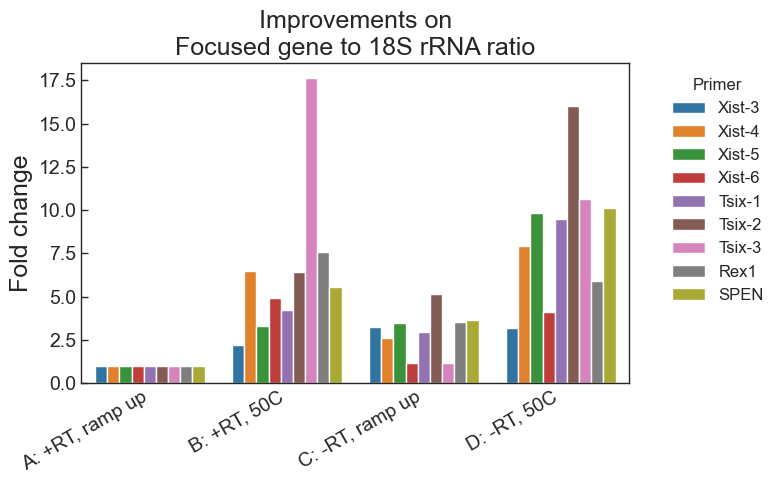

In [93]:
ddcp_column = "ddCp_by18S_comparetoA"
title = "Improvements on\nFocused gene to 18S rRNA ratio"
output_file = "Improvements on Focused gene to 18S rRNA ratio.png"
primers_to_plot = [
    # "gDNA_Neg1",
    # "gDNA_Neg2",
    # "18S",
    "Xist-3",
    "Xist-4",
    "Xist-5",
    "Xist-6",
    "Tsix-1",
    "Tsix-2",
    "Tsix-3",
    "Rex1",
    "SPEN",
]
condition_order = ["A: +RT, ramp up", "B: +RT, 50C", "C: -RT, ramp up", "D: -RT, 50C"]
figsize = (8, 5)
palette = "tab10"

# Load data
df_currentplot = df_plot.copy()

# Calculate fold change: 2^(-ddCp)
df_currentplot["Fold_Change"] = 2 ** (-df_currentplot[ddcp_column])
df_currentplot = df_currentplot[df_currentplot["Primer"].isin(primers_to_plot)]
# Remove unused categories from Primer column
df_currentplot["Primer"] = df_currentplot["Primer"].cat.remove_unused_categories()

# Create plot
plt.figure(figsize=figsize)
ax = sns.barplot(
    data=df_currentplot,
    x="Condition",
    y="Fold_Change",
    hue="Primer",
    order=condition_order,
    palette=palette,
    errorbar=None,  # Set to ("ci", 95) if you have replicates
)

# Formatting
plt.xlabel("")
plt.ylabel("Fold change", fontsize=18)
plt.title(title, fontsize=18)
plt.xticks(rotation=30, ha="right")

# Spine and tick formatting
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=14,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)

# Legend formatting
plt.legend(
    title="Primer",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=12,
    frameon=False,
)

plt.tight_layout()
plt.savefig(output_file, format=output_file[-3:], bbox_inches="tight", dpi=600)
plt.show()

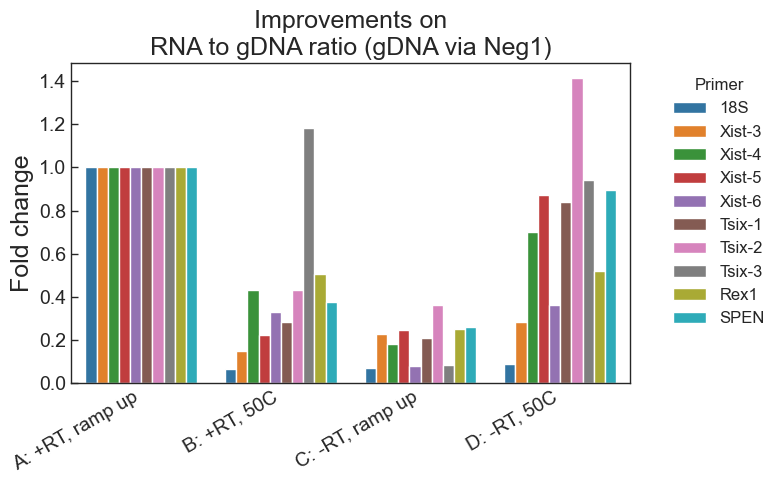

In [94]:
ddcp_column = "ddCp_normby_Neg1_comparetoA"
title = "Improvements on\nRNA to gDNA ratio (gDNA via Neg1)"
output_file = "Improvements on RNA to 18S gDNA ratio-Neg1.png"
primers_to_plot = [
    # "gDNA_Neg1",
    # "gDNA_Neg2",
    "18S",
    "Xist-3",
    "Xist-4",
    "Xist-5",
    "Xist-6",
    "Tsix-1",
    "Tsix-2",
    "Tsix-3",
    "Rex1",
    "SPEN",
]
condition_order = ["A: +RT, ramp up", "B: +RT, 50C", "C: -RT, ramp up", "D: -RT, 50C"]
figsize = (8, 5)
palette = "tab10"

# Load data
df_currentplot = df_plot.copy()

# Calculate fold change: 2^(-ddCp)
df_currentplot["Fold_Change"] = 2 ** (-df_currentplot[ddcp_column])
df_currentplot = df_currentplot[df_currentplot["Primer"].isin(primers_to_plot)]
# Remove unused categories from Primer column
df_currentplot["Primer"] = df_currentplot["Primer"].cat.remove_unused_categories()

# Create plot
plt.figure(figsize=figsize)
ax = sns.barplot(
    data=df_currentplot,
    x="Condition",
    y="Fold_Change",
    hue="Primer",
    order=condition_order,
    palette=palette,
    errorbar=None,  # Set to ("ci", 95) if you have replicates
)

# Formatting
plt.xlabel("")
plt.ylabel("Fold change", fontsize=18)
plt.title(title, fontsize=18)
plt.xticks(rotation=30, ha="right")

# Spine and tick formatting
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=14,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)

# Legend formatting
plt.legend(
    title="Primer",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=12,
    frameon=False,
)

plt.tight_layout()
plt.savefig(output_file, format=output_file[-3:], bbox_inches="tight", dpi=600)
plt.show()

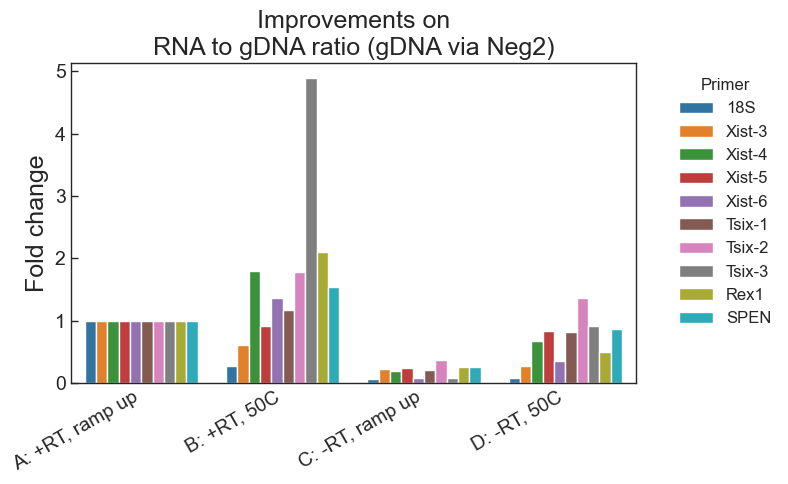

In [95]:
ddcp_column = "ddCp_normby_Neg2_comparetoA"
title = "Improvements on\nRNA to gDNA ratio (gDNA via Neg2)"
output_file = "Improvements on RNA to 18S gDNA ratio-Neg2.png"
primers_to_plot = [
    # "gDNA_Neg1",
    # "gDNA_Neg2",
    "18S",
    "Xist-3",
    "Xist-4",
    "Xist-5",
    "Xist-6",
    "Tsix-1",
    "Tsix-2",
    "Tsix-3",
    "Rex1",
    "SPEN",
]
condition_order = ["A: +RT, ramp up", "B: +RT, 50C", "C: -RT, ramp up", "D: -RT, 50C"]
figsize = (8, 5)
palette = "tab10"

# Load data
df_currentplot = df_plot.copy()

# Calculate fold change: 2^(-ddCp)
df_currentplot["Fold_Change"] = 2 ** (-df_currentplot[ddcp_column])
df_currentplot = df_currentplot[df_currentplot["Primer"].isin(primers_to_plot)]
# Remove unused categories from Primer column
df_currentplot["Primer"] = df_currentplot["Primer"].cat.remove_unused_categories()

# Create plot
plt.figure(figsize=figsize)
ax = sns.barplot(
    data=df_currentplot,
    x="Condition",
    y="Fold_Change",
    hue="Primer",
    order=condition_order,
    palette=palette,
    errorbar=None,  # Set to ("ci", 95) if you have replicates
)

# Formatting
plt.xlabel("")
plt.ylabel("Fold change", fontsize=18)
plt.title(title, fontsize=18)
plt.xticks(rotation=30, ha="right")

# Spine and tick formatting
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=14,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)

# Legend formatting
plt.legend(
    title="Primer",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=12,
    frameon=False,
)

plt.tight_layout()
plt.savefig(output_file, format=output_file[-3:], bbox_inches="tight", dpi=600)
plt.show()